La idea es ver qué sucede con un entrenamiento sólo de problemas en inglés, después mixto haciendo over sampling, under sampling y tal cual viene el dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DRIVE_PATH = "/content/drive/MyDrive/Competitive-programming-problems-classification/Github/Competitive-programming-problems-classification/backend"

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm
from pprint import pprint

(14455, 2)
greedy             3291
math               2998
data structures    2452
sortings           1692
graphs             1423
number theory      1114
strings             919
geometry            566
Name: category, dtype: int64


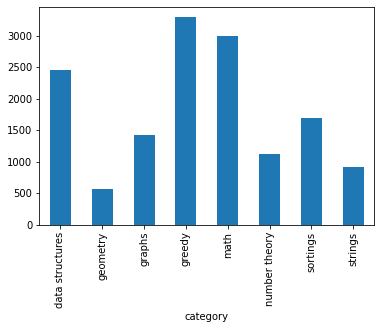

In [ ]:
import json 

startingTopics = [
    "sortings",
    "strings",
    "greedy",
    "number theory",
    "math",
    "graphs",
    "geometry",
    "data structures",
]

def getAllProblems():
  problems = []
  folder = "/content/drive/MyDrive/Competitive-programming-problems-classification/Github/Competitive-programming-problems-classification/backend"
  for topic in startingTopics:
    codeforcesProblems = json.load(open(f"{folder}/data/codeforces-{topic}.json"))
    problems.extend(codeforcesProblems)
    # omegaupProblems = json.load(open(f"data/omegaup-{topic}.json"))
    # problems.extend(omegaupProblems)

  return problems

# Shrink list of topics to nlp.startingTopics only
# Duplicate problems for each category
problems = getAllProblems()

problemsForDf = []
for problem in problems:
  for topic in problem['topics']:
    if topic in startingTopics:
      problemsForDf.append({
        'text': problem['history'],
        'category': topic,
      })

df = pd.DataFrame(problemsForDf)

def showCategories(df, title='Categories count'):
  print(df.category.value_counts())
  df.groupby(['category']).size().plot.bar()

print(df.shape)
showCategories(df)


In [ ]:
def getTopicIndexMap():
  map = {}
  for index, topic in enumerate(startingTopics):
    map[topic] = int(index)
  return map

topicIndexMap = getTopicIndexMap()
topicIndexMap

{'sortings': 0,
 'strings': 1,
 'greedy': 2,
 'number theory': 3,
 'math': 4,
 'graphs': 5,
 'geometry': 6,
 'data structures': 7}

In [ ]:
# Oversampling and under sampling
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss

def sampleData(df, strategy):
  x = df.drop('category', axis=1)
  y = df['category']
  x_sample, y_sample = strategy.fit_resample(x, y)
  new_df = pd.concat(
      [pd.DataFrame(x_sample), pd.DataFrame(y_sample, columns=['category'])], 
      axis=1
  )
  print(new_df.shape)
  return new_df

(26328, 2)
greedy             3291
sortings           3291
math               3291
strings            3291
graphs             3291
data structures    3291
number theory      3291
geometry           3291
Name: category, dtype: int64


,text,category
0,You are participating in Yet Another Tournamen...,greedy
1,You are participating in Yet Another Tournamen...,sortings
2,An array a is called ugly if it contains at le...,math
3,An array a is called ugly if it contains at le...,sortings
4,Let' s call a string balanced if all character...,greedy


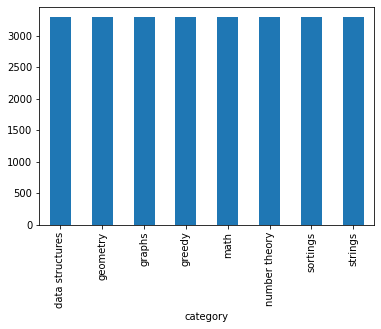

In [ ]:
ros = RandomOverSampler(random_state=42)
over_sampling_df = sampleData(df, ros)
showCategories(over_sampling_df, title="RandomOverSampler")
over_sampling_df.head()

(4528, 2)
data structures    566
geometry           566
graphs             566
greedy             566
math               566
number theory      566
sortings           566
strings            566
Name: category, dtype: int64


,text,category
0,Genos and Saitama went shopping for Christmas ...,data structures
1,This is the hard version of the problem. The o...,data structures
2,Tokitsukaze has a permutation p of length n . ...,data structures
3,"After Fox Ciel got off a bus, she found that t...",data structures
4,The only difference between easy and hard vers...,data structures


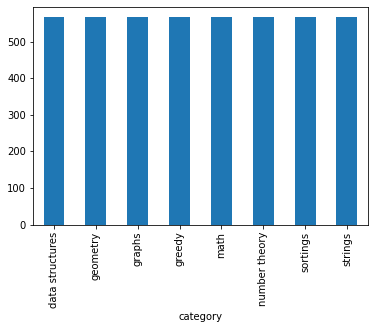

In [ ]:
rus = RandomUnderSampler(random_state=42)
under_sampling_df = sampleData(df, rus)
showCategories(under_sampling_df, title="RandomUnderSampler")
under_sampling_df.head()

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.labels = [topicIndexMap[topic] for topic in df['category']]
        self.texts = [tokenizer(
            text,
            padding = 'max_length',
            max_length = 512, 
            truncation = True,
            return_tensors = "pt") 
        for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y

In [ ]:
class BertClassifier(nn.Module):
    def __init__(self, dropout=0.5):
        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear_bert = nn.Linear(768, len(topicIndexMap))
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):
        _, pooled_output = self.bert(
            input_ids = input_id, 
            attention_mask = mask, 
            return_dict = False
        )
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear_bert(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [ ]:
import os

def train(title, model, train_data, validation_data, learning_rate, epochs):
    train = Dataset(train_data)
    validation = Dataset(validation_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    validation_dataloader = torch.utils.data.DataLoader(validation, batch_size=2)

    use_cuda = torch.cuda.is_available()
    print(f"Use cuda {use_cuda}")
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr = learning_rate)

    if use_cuda:
            model = model.cuda()
            criterion = criterion.cuda()

    path = "/content/drive/MyDrive/Competitive-programming-problems-classification/Github/Competitive-programming-problems-classification/backend/training"
    checkpoint_used = False

    for epoch in range(epochs):
        current_file_name = f"{path}/{title}_{epoch}.pt"

        if not checkpoint_used:
          if os.path.isfile(current_file_name):
              # There is a checkpoint version, don't do anything :)
              continue
          else:
              # No checkpoint for this epoch, let's check what to do D: 
              if epoch != 0:
                  # Read the previous checkpoint and start from there
                  checkpoint_file_name = f"{path}/{title}_{epoch - 1}.pt"
                  print(f"Loading checkpoint {title} from epoch {epoch - 1} ...")
                  checkpoint = torch.load(checkpoint_file_name)
                  model.load_state_dict(checkpoint['model_state_dict'])
                  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                  print(f"Checkpoint {title} from epoch {epoch - 1} loaded correctly")
                  checkpoint_used = True
              else:
                  # There is no -1 version, so just keep going  
                  checkpoint_used = True

        total_acc_train = 0
        total_loss_train = 0

        for train_input, train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)
            
            batch_loss = criterion(output, train_label.long())
            total_loss_train += batch_loss.item()
            
            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()
        
        # total_acc_validation = 0
        # total_loss_validation = 0

        # with torch.no_grad():
        #     for validation_input, validation_label in validation_dataloader:

        #         validation_label = validation_label.to(device)
        #         mask = validation_input['attention_mask'].to(device)
        #         input_id = validation_input['input_ids'].squeeze(1).to(device)

        #         output = model(input_id, mask)

        #         batch_loss = criterion(output, validation_label.long())
        #         total_loss_validation += batch_loss.item()
                
        #         acc = (output.argmax(dim=1) == validation_label).sum().item()
        #         total_acc_validation += acc
        
        print(
            f'{title} epoch: {epoch} \n\
            | Train Loss: {total_loss_train / len(train_data): .3f} \n\
            | Train Accuracy: {total_acc_train / len(train_data): .3f} \n')
            # | Validation Loss: {total_loss_validation / len(validation_data): .3f} \n\
            # | Validation Accuracy: {total_acc_validation / len(validation_data): .3f} \n\n')
        
        torch.save({
          # 'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
        }, current_file_name)
                  

In [ ]:
def evaluate(title, model, test_data):
    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():
        for test_input, test_label in test_dataloader:
              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'{title} test Accuracy: {total_acc_test / len(test_data): .3f}')
    return total_acc_test / len(test_data)

In [ ]:
def getTrainValidationTestDataFrames(df):
    # Divides the dataset in 3 chunks [80%, 10%, 10%] 
    np.random.seed(123)
    df_train, df_validation, df_test = np.split(
        df,
        [int(.8*len(df)), int(.9*len(df))]
    )
    return df_train, df_validation, df_test
    
def quickExperiment(title, df, epochs):
    df_train, df_validation, df_test = getTrainValidationTestDataFrames(df)

    print(f"Starting {title} experiment train: {len(df_train)}, validation: {len(df_validation)}, test: {len(df_test)}")

    model = BertClassifier()
    learning_rate = 1e-6
                  
    train(title, model, df_train, df_validation, learning_rate, epochs)
    evaluate(model, df_test)

    return model

In [ ]:
from sklearn.utils import shuffle
from multiprocessing import Pool
import math
import itertools

def experiment(title, df, num_batches, epochs):
    # Shuffle the dataset to increase a more balanced data set for each small training 
    df = shuffle(df, random_state=123)

    np.random.seed(123)
    df_size = df.shape[0]
    batch_size = int(df_size / num_batches)
    indices = [i * batch_size for i in range(1, num_batches)]
    df_batches = np.split(df, indices)

    epochs_arr = itertools.repeat(epochs, len(df_batches))
    titles_arr = [f"{title}{i}" for i in range(0, len(df_batches))]

    with Pool(processes = len(df_batches)) as pool:
        models = pool.starmap(quickExperiment, zip(titles_arr, df_batches, epochs_arr))

    return models

In [ ]:
over_sampling_model = experiment("OverSampling", over_sampling_df, num_batches = 5, epochs = 5)

NameError: ignored

In [ ]:
import matplotlib.pyplot as plt

def plotResults(title, df, epochs = 5):
    model = BertClassifier()
    df_train, df_validation, df_test = getTrainValidationTestDataFrames(df)

    # train_results = []
    validation_results = []
    test_results = []
    for epoch in range(0, epochs):
        checkpoint_file_name = f"{DRIVE_PATH}/training/{title}_{epoch}.pt"
        checkpoint = torch.load(checkpoint_file_name)
        model.load_state_dict(checkpoint['model_state_dict'])

        # train_results.append(evaluate(model, df_train))
        validation_results.append(evaluate(model, df_validation))
        test_results.append(evaluate(model, df_test))
      
    epochs = range(0, epochs)
    # plt.plot(epochs, train_results, 'b', label='Training accuracy')
    plt.plot(epochs, validation_results, 'g', label='Validation accuracy')
    # df_test is unseen data to avoid overfitting
    plt.plot(epochs, test_results, 'r', label='Test accuracy')
    plt.title('Accuracy results')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    return validation_results, test_results

validation_results, test_results = plotResults("OverSampling", over_sampling_df)